<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week4/MHEALTH_final_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau # 학습률 스케줄러 추가
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from scipy.fft import fft
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import glob
import os
import warnings

In [2]:
# --- 1. Data Loading and Merging ---
print("--- 1. Data Loading and Merging ---")
# Specify the path to the dataset on Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET'

if not os.path.isdir(path):
    print(f"⚠️ Error: Directory not found: {path}")
else:
    # Find all files matching the pattern
    all_files = sorted(glob.glob(os.path.join(path, "mHealth_subject*.log")))
    if not all_files:
        print(f"⚠️ Error: No 'mHealth_subject*.log' files found in '{path}'.")
    else:
        # Assuming 10 subject files are provided as per the requirement
        print(f"Found {len(all_files)} subject files. Assuming 10 for cross-validation setup.")
        li = []
        column_names = [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
            'ecg_lead1', 'ecg_lead2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
            'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
            'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
            'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
            'label'
        ]
        feature_cols = column_names[:-1]

        for filename in all_files:
            df_temp = pd.read_csv(filename, header=None, sep=r'\s+')
            df_temp.columns = column_names
            subject_id = int(''.join(filter(str.isdigit, os.path.basename(filename))))
            df_temp['subject'] = subject_id
            li.append(df_temp)

        df = pd.concat(li, axis=0, ignore_index=True)
        # Remove Null class (label 0) as it is not an activity
        df = df[df['label'] != 0].reset_index(drop=True)

        print("✅ Data loaded and Null class removed successfully.")
        print(f"Overall data shape: {df.shape}")
        display(df.head())

--- 1. Data Loading and Merging ---
Found 10 subject files. Assuming 10 for cross-validation setup.
✅ Data loaded and Null class removed successfully.
Overall data shape: (343195, 25)


,acc_chest_x,acc_chest_y,acc_chest_z,ecg_lead1,ecg_lead2,acc_ankle_x,acc_ankle_y,acc_ankle_z,gyro_ankle_x,gyro_ankle_y,...,acc_arm_y,acc_arm_z,gyro_arm_x,gyro_arm_y,gyro_arm_z,mag_arm_x,mag_arm_y,mag_arm_z,label,subject
0,-9.7788,0.55690,1.19750,0.008373,-0.033490,2.6493,-9.4517,0.37683,-0.20965,-0.88931,...,-9.0618,1.8177,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,1,1
1,-9.7733,0.27880,0.73036,-0.025118,-0.025118,2.4157,-9.5306,0.40179,-0.20965,-0.88931,...,-9.2048,1.5189,-0.058824,-0.93429,-0.34483,0.719910,0.17803,0.37363,1,1
2,-9.8609,0.11561,0.79988,0.025118,0.016745,2.3865,-9.5991,0.48141,-0.20037,-0.86867,...,-9.1945,1.5507,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,1,1
3,-9.7409,0.17652,0.88957,0.180010,0.129770,2.3758,-9.5997,0.42919,-0.20037,-0.86867,...,-9.1746,1.5413,-0.078431,-0.93429,-0.34052,0.357180,-0.18858,-0.35198,1,1
4,-9.7821,0.21637,0.90368,0.092098,0.046049,2.3239,-9.5406,0.40038,-0.20037,-0.86867,...,-9.2039,1.6127,-0.078431,-0.93429,-0.34052,-0.001887,-0.18867,-0.72017,1,1


In [3]:
# --- 2. Exploratory Data Analysis (EDA) ---
print("\n--- 2. Exploratory Data Analysis (EDA) ---")
# Add activity names for better visualization
activity_mapping = {
    1: 'Standing still', 2: 'Sitting and relaxing', 3: 'Lying down',
    4: 'Walking', 5: 'Climbing stairs', 6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 8: 'Knees bending (crouching)',
    9: 'Cycling', 10: 'Jogging', 11: 'Running', 12: 'Jump front & back'
}
df['activity'] = df['label'].map(activity_mapping)


--- 2. Exploratory Data Analysis (EDA) ---


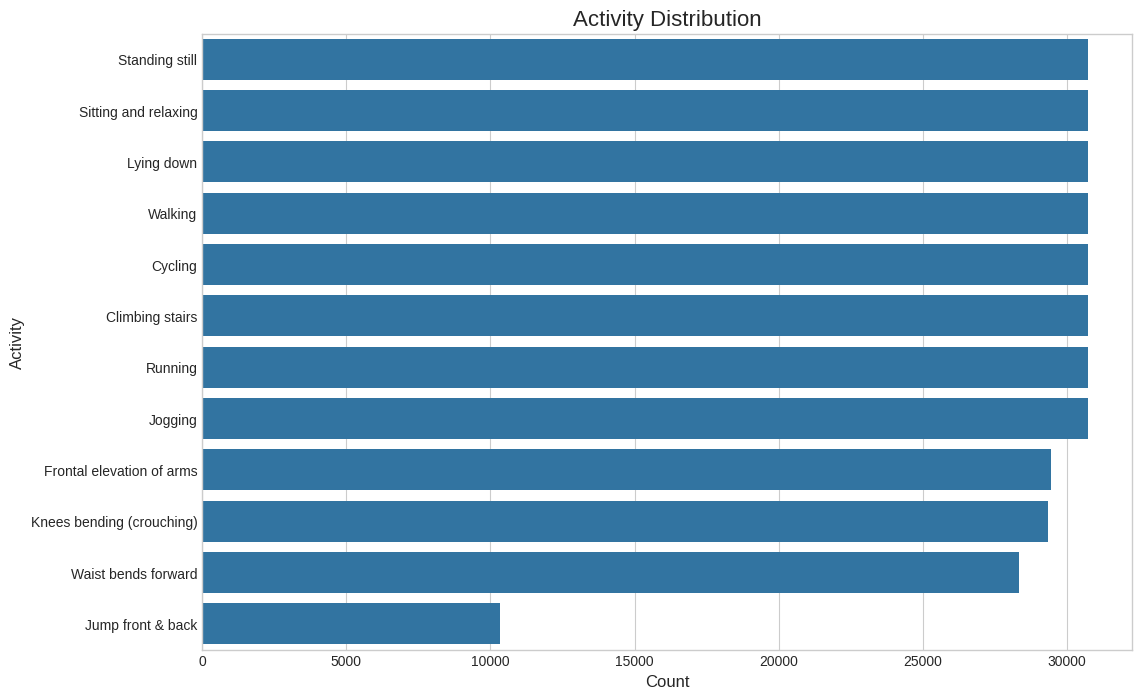

In [4]:
# Plot activity distribution
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))
sns.countplot(y='activity', data=df, order=df['activity'].value_counts().index)
plt.title('Activity Distribution', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Activity', fontsize=12)
plt.show()

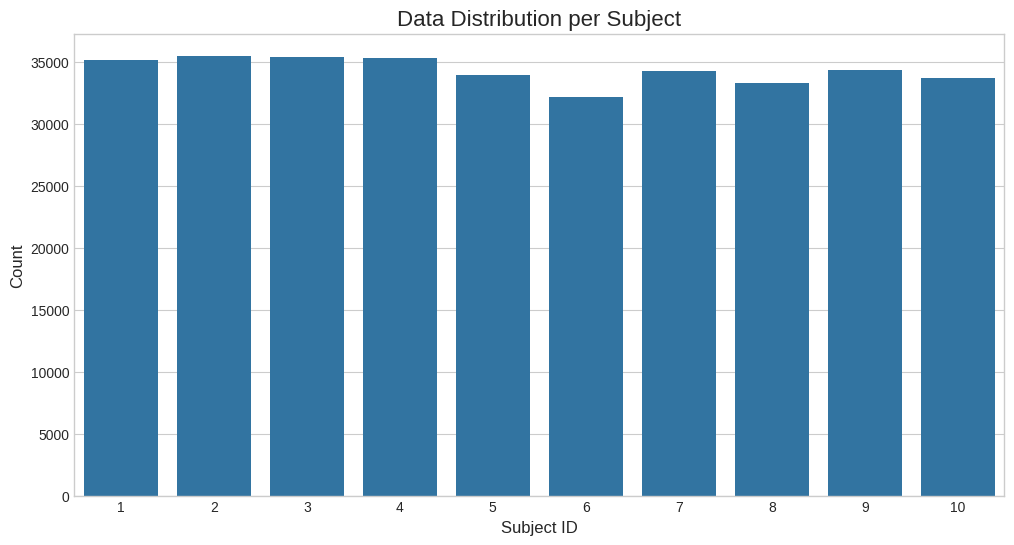

In [5]:
# Plot data distribution per subject
plt.figure(figsize=(12, 6))
sns.countplot(x='subject', data=df)
plt.title('Data Distribution per Subject', fontsize=16)
plt.xlabel('Subject ID', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [6]:
# --- 3. Feature Engineering & Sliding Window Segmentation (Memory-Optimized) ---
print("\n--- 3. Starting Feature Engineering and Segmentation ---")

def get_fft_features(segment, n_fft=64):
    """Extract features from FFT"""
    fft_vals = fft(segment, n=n_fft)
    fft_abs = np.abs(fft_vals)
    return fft_abs[:n_fft // 2]

def create_segments_and_features_optimized(df, time_steps, step, feature_cols):
    # Calculate the exact number of segments that will be created
    num_segments = (len(df) - time_steps) // step + 1

    # Pre-allocate NumPy arrays to store the results
    raw_segments = np.empty((num_segments, time_steps, len(feature_cols)))
    num_engineered_features = 23 * 4 + 23 * 32
    engineered_features = np.empty((num_segments, num_engineered_features))

    labels = np.empty(num_segments, dtype=int)
    users = np.empty(num_segments, dtype=int)

    label_values = df['label'].values
    user_values = df['subject'].values

    idx = 0
    for i in range(0, len(df) - time_steps + 1, step):
        segment_df = df[feature_cols].iloc[i: i + time_steps]
        raw_segments[idx] = segment_df.values

        # Time-domain features
        mean = segment_df.mean().values
        std = segment_df.std().values
        maxx = segment_df.max().values
        minn = segment_df.min().values

        # Frequency-domain features
        fft_features = np.array([get_fft_features(segment_df[col].values) for col in feature_cols]).flatten()

        # Combine all features
        engineered_features[idx] = np.concatenate([mean, std, maxx, minn, fft_features])

        # Label and User info
        label_result = stats.mode(label_values[i: i + time_steps], keepdims=True).mode[0]
        labels[idx] = np.array(label_result).flatten()[0]
        users[idx] = user_values[i]

        idx += 1

    return raw_segments, engineered_features, labels, users

# Parameters
Fs = 50
TIME_STEPS = int(Fs * 2.56)  # 128
STEP_SIZE = int(TIME_STEPS * 0.5) # 64


--- 3. Starting Feature Engineering and Segmentation ---


In [7]:
X_raw, X_feat, y, groups = create_segments_and_features_optimized(df, TIME_STEPS, STEP_SIZE, feature_cols)
# Adjust labels to start from 0
y = y - 1
NUM_CLASSES = len(np.unique(y))

# Create a LabelEncoder for mapping names in the final report
le = LabelEncoder()
le.fit(list(activity_mapping.values()))

print(f"✅ Feature engineered segments created. Shape: X_raw={X_raw.shape}, X_feat={X_feat.shape}, y={y.shape}, groups={groups.shape}")
print(f"Number of classes: {NUM_CLASSES}")

✅ Feature engineered segments created. Shape: X_raw=(5361, 128, 23), X_feat=(5361, 828), y=(5361,), groups=(5361,)
Number of classes: 12


In [12]:
# --- 4. Hybrid Model with Attention ---
class HAR_Hybrid_Attention_Model(nn.Module):
    def __init__(self, num_classes, num_raw_features, num_eng_features):
        super(HAR_Hybrid_Attention_Model, self).__init__()
        # Branch 1: CNN-LSTM
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=num_raw_features, out_channels=64, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        # Set num_layers=2 to use dropout effectively
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, batch_first=True, dropout=0.5)

        # Branch 2: FNN
        self.fnn_layers = nn.Sequential(
            nn.Linear(num_eng_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # Attention Mechanism to weigh the branches
        self.attention_weights = nn.Linear(128 + 256, 2)

        # Classifier
        self.classifier = nn.Linear(128 + 256, num_classes)

    def forward(self, x_raw, x_feat):
        # CNN-LSTM Branch
        x1 = x_raw.permute(0, 2, 1)
        x1 = self.conv_layers(x1)
        x1 = x1.permute(0, 2, 1)
        x1, _ = self.lstm(x1)
        x1 = x1[:, -1, :]

        # FNN Branch
        x2 = self.fnn_layers(x_feat)

        # Concatenate for attention
        combined_for_attention = torch.cat((x1, x2), dim=1)

        # Calculate attention scores
        attention_scores = torch.softmax(self.attention_weights(combined_for_attention), dim=1)

        # Apply attention
        attended_x1 = x1 * attention_scores[:, 0].unsqueeze(1)
        attended_x2 = x2 * attention_scores[:, 1].unsqueeze(1)

        # Concatenate attended features
        combined_attended = torch.cat((attended_x1, attended_x2), dim=1)

        # Final classification
        out = self.classifier(combined_attended)
        return out

In [14]:
# --- 5. Subject-wise Cross-Validation ---
print("\n--- 5. Starting Subject-wise Cross-Validation ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

N_SPLITS = 5
gkf = GroupKFold(n_splits=N_SPLITS)

fold_results = []
fold_accuracies = []
all_preds = []
all_labels = []


--- 5. Starting Subject-wise Cross-Validation ---
Using device: cuda


In [15]:
for fold, (train_val_idx, test_idx) in enumerate(gkf.split(X_raw, y, groups)):
    print(f"\n========== Fold {fold+1}/{N_SPLITS} ==========")

    model = HAR_Hybrid_Attention_Model(NUM_CLASSES, X_raw.shape[2], X_feat.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # Split both feature datasets
    X_raw_train_val, X_raw_test = X_raw[train_val_idx], X_raw[test_idx]
    X_feat_train_val, X_feat_test = X_feat[train_val_idx], X_feat[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]

    # Data Scaling
    scaler_raw = StandardScaler()
    X_raw_train_val = scaler_raw.fit_transform(X_raw_train_val.reshape(-1, X_raw_train_val.shape[2])).reshape(X_raw_train_val.shape)
    X_raw_test = scaler_raw.transform(X_raw_test.reshape(-1, X_raw_test.shape[2])).reshape(X_raw_test.shape)

    scaler_feat = StandardScaler()
    X_feat_train_val = scaler_feat.fit_transform(X_feat_train_val)
    X_feat_test = scaler_feat.transform(X_feat_test)

    # Split train_val into train and validation sets
    X_raw_train, X_raw_val, X_feat_train, X_feat_val, y_train, y_val = train_test_split(
        X_raw_train_val, X_feat_train_val, y_train_val, test_size=0.1, random_state=42, stratify=y_train_val)

    # Create Tensors and DataLoaders
    train_dataset = TensorDataset(torch.tensor(X_raw_train, dtype=torch.float32),
                                  torch.tensor(X_feat_train, dtype=torch.float32),
                                  torch.tensor(y_train, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_raw_val, dtype=torch.float32),
                                torch.tensor(X_feat_val, dtype=torch.float32),
                                torch.tensor(y_val, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_raw_test, dtype=torch.float32),
                                 torch.tensor(X_feat_test, dtype=torch.float32),
                                 torch.tensor(y_test, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Model Training
    NUM_EPOCHS = 40
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for segments_raw, segments_feat, labels in train_loader:
            segments_raw, segments_feat, labels = segments_raw.to(device), segments_feat.to(device), labels.to(device)

            outputs = model(segments_raw, segments_feat)
            loss = criterion(outputs, labels)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)

        model.eval()
        running_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for segments_raw, segments_feat, labels in val_loader:
                segments_raw, segments_feat, labels = segments_raw.to(device), segments_feat.to(device), labels.to(device)
                outputs = model(segments_raw, segments_feat)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)

        scheduler.step(val_loss)

        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    fold_results.append(history)

    # Model Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for segments_raw, segments_feat, labels in test_loader:
            segments_raw, segments_feat, labels = segments_raw.to(device), segments_feat.to(device), labels.to(device)
            outputs = model(segments_raw, segments_feat)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    fold_accuracies.append(accuracy)
    print(f'✅ Fold {fold+1} Test Accuracy: {accuracy:.2f} %')


========== Fold 1/5 ==========
Epoch [1/40], Train Loss: 0.9406, Train Acc: 72.26%, Val Loss: 0.2779, Val Acc: 96.98%
Epoch [2/40], Train Loss: 0.2543, Train Acc: 93.72%, Val Loss: 0.1434, Val Acc: 97.68%
Epoch [3/40], Train Loss: 0.1440, Train Acc: 97.34%, Val Loss: 0.0882, Val Acc: 99.07%
Epoch [4/40], Train Loss: 0.0927, Train Acc: 98.22%, Val Loss: 0.0661, Val Acc: 99.07%
Epoch [5/40], Train Loss: 0.0619, Train Acc: 99.02%, Val Loss: 0.0526, Val Acc: 99.30%
Epoch [6/40], Train Loss: 0.0464, Train Acc: 99.20%, Val Loss: 0.0469, Val Acc: 99.30%
Epoch [7/40], Train Loss: 0.0357, Train Acc: 99.51%, Val Loss: 0.0460, Val Acc: 99.30%
Epoch [8/40], Train Loss: 0.0271, Train Acc: 99.56%, Val Loss: 0.0431, Val Acc: 99.54%
Epoch [9/40], Train Loss: 0.0194, Train Acc: 99.72%, Val Loss: 0.0420, Val Acc: 99.54%
Epoch [10/40], Train Loss: 0.0165, Train Acc: 99.77%, Val Loss: 0.0400, Val Acc: 99.54%
Epoch [11/40], Train Loss: 0.0138, Train Acc: 99.79%, Val Loss: 0.0427, Val Acc: 99.54%
Epoch [12


--- 6. Training History Visualization ---


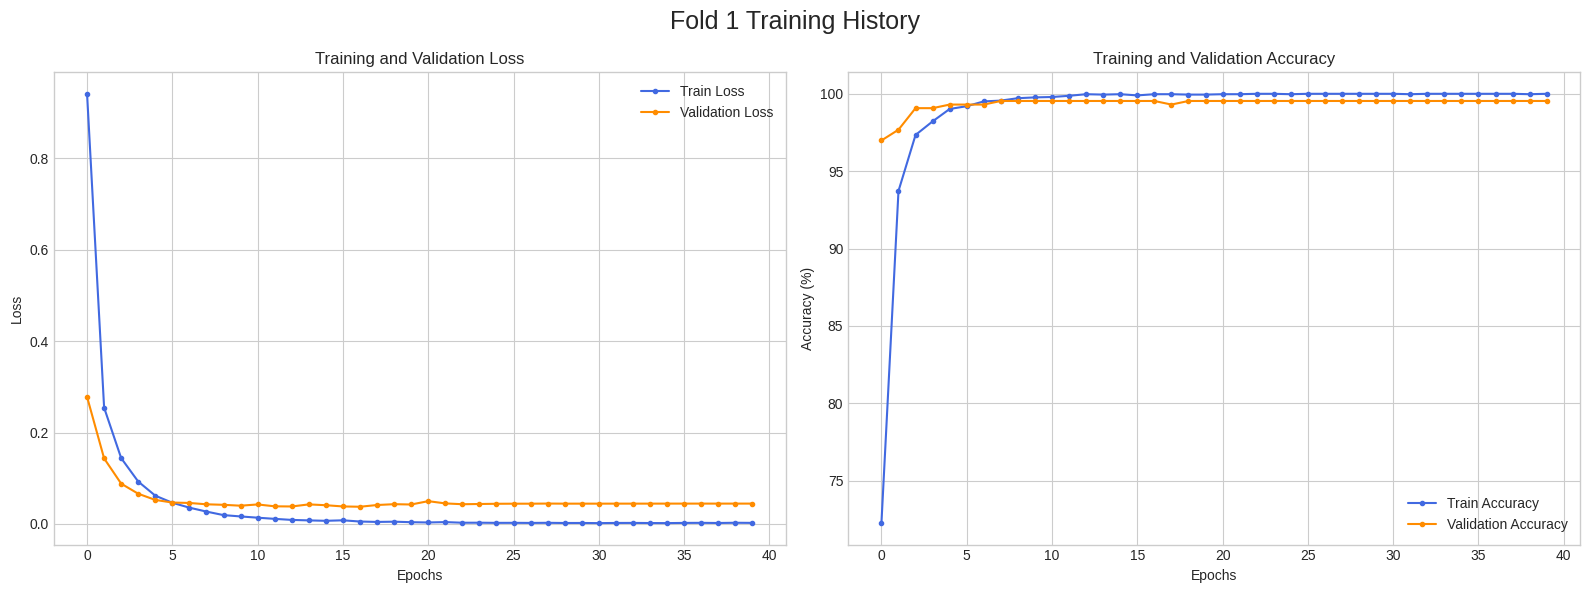

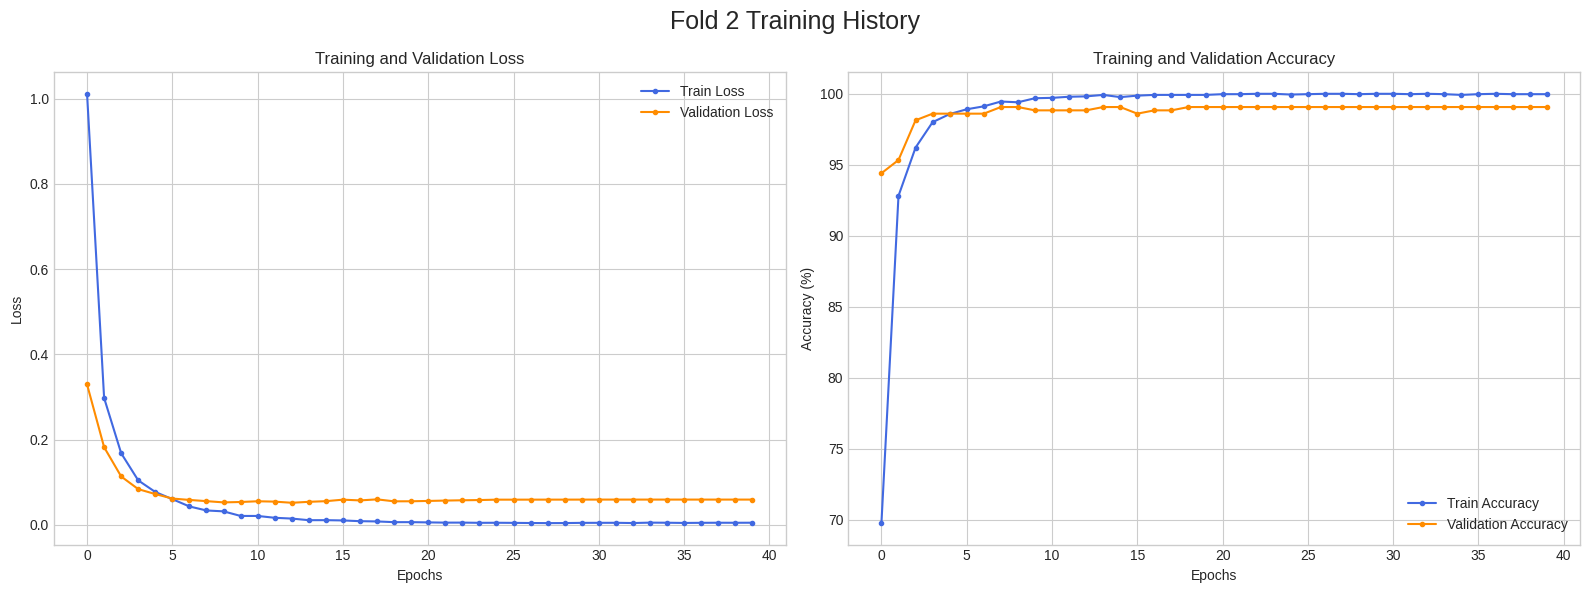

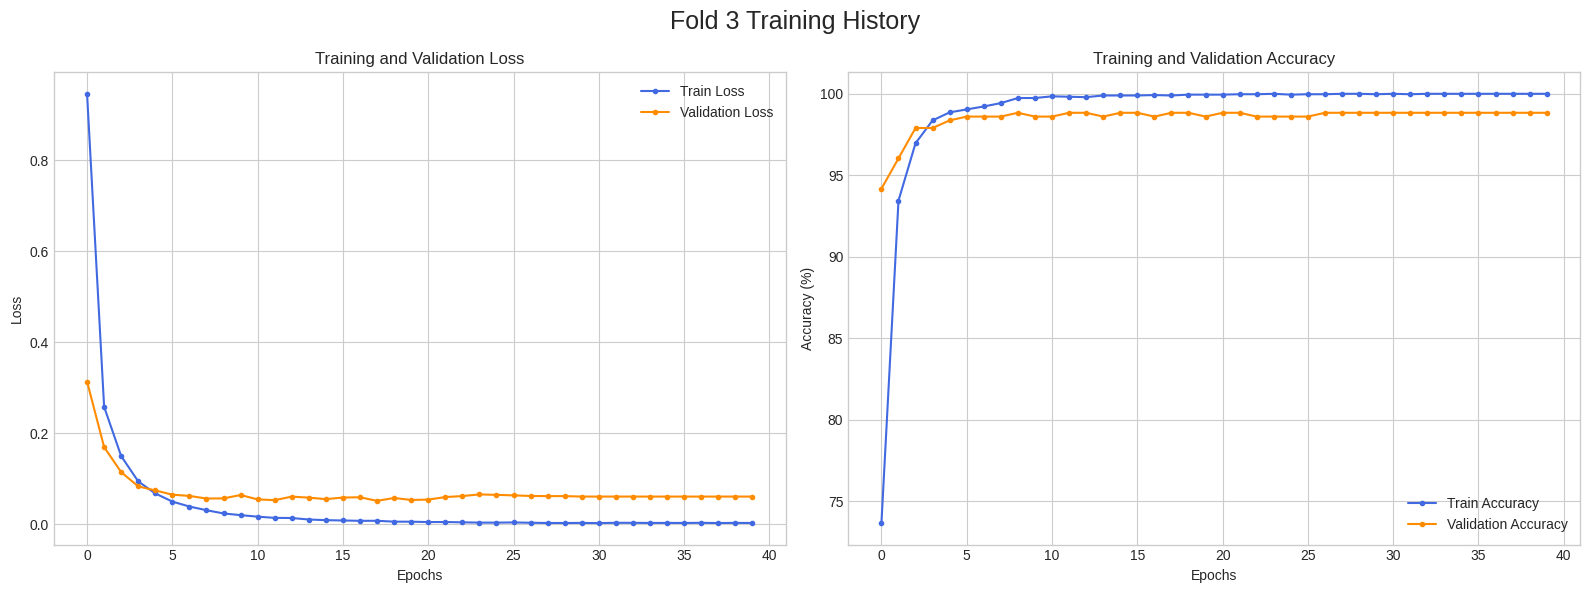

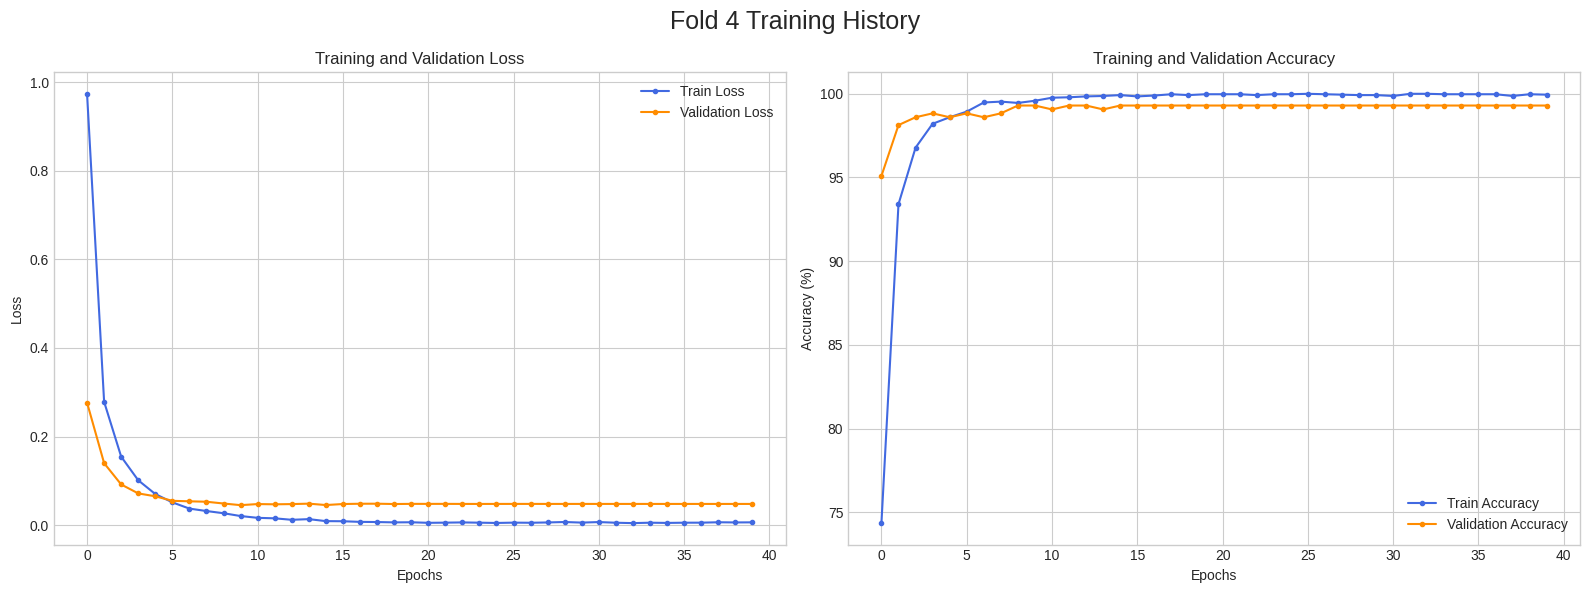

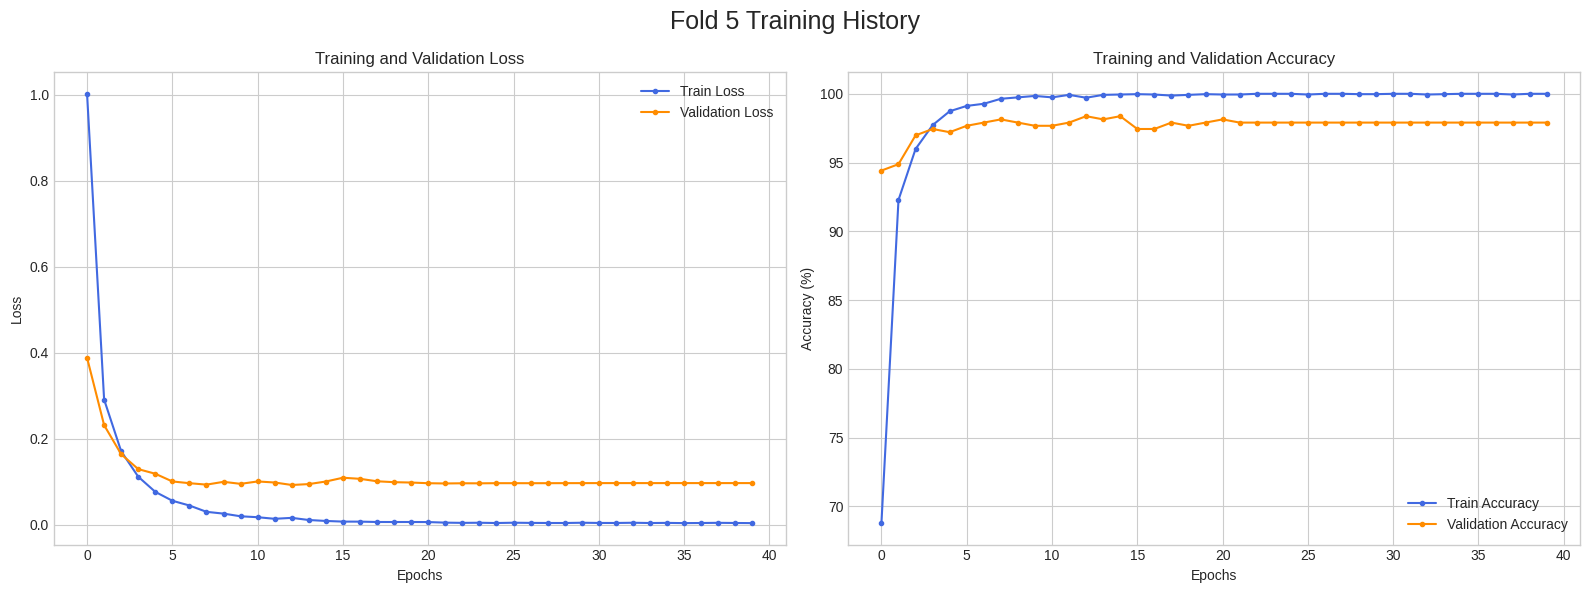

In [17]:
# --- 6. Training History Visualization ---
print("\n--- 6. Training History Visualization ---")
for i, history in enumerate(fold_results):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Fold {i+1} Training History', fontsize=18)

    ax1.plot(history['train_loss'], label='Train Loss', color='royalblue', marker='o', markersize=3)
    ax1.plot(history['val_loss'], label='Validation Loss', color='darkorange', marker='o', markersize=3)
    ax1.set_title('Training and Validation Loss'); ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss'); ax1.legend()

    ax2.plot(history['train_acc'], label='Train Accuracy', color='royalblue', marker='o', markersize=3)
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='darkorange', marker='o', markersize=3)
    ax2.set_title('Training and Validation Accuracy'); ax2.set_xlabel('Epochs'); ax2.set_ylabel('Accuracy (%)'); ax2.legend()

    plt.tight_layout(); plt.show()

In [16]:
# --- 7. Final Results ---
print("\n\n--- 7. Final Cross-Validation Results ---")
accuracies_np = np.array(fold_accuracies)
print(f"Accuracy per Fold: {accuracies_np}")
print(f"Average Accuracy: {accuracies_np.mean():.2f} %"); print(f"Standard Deviation of Accuracy: {accuracies_np.std():.2f}")



--- 7. Final Cross-Validation Results ---
Accuracy per Fold: [89.6128423  96.93877551 95.71295433 95.46716004 98.78504673]
Average Accuracy: 95.30 %
Standard Deviation of Accuracy: 3.08



--- 8. Classification Report & Confusion Matrix ---
                           precision    recall  f1-score   support

          Climbing stairs       0.99      0.98      0.99       483
                  Cycling       0.99      0.99      0.99       480
Frontal elevation of arms       1.00      1.00      1.00       480
                  Jogging       0.99      0.99      0.99       480
        Jump front & back       0.96      0.97      0.97       479
Knees bending (crouching)       0.97      0.99      0.98       442
               Lying down       0.99      1.00      0.99       460
                  Running       0.94      0.95      0.94       458
     Sitting and relaxing       0.99      0.94      0.96       480
           Standing still       0.91      0.76      0.83       480
      Waist bends forward       0.79      0.93      0.86       480
                  Walking       0.94      0.94      0.94       159

                 accuracy                           0.95      5361
       

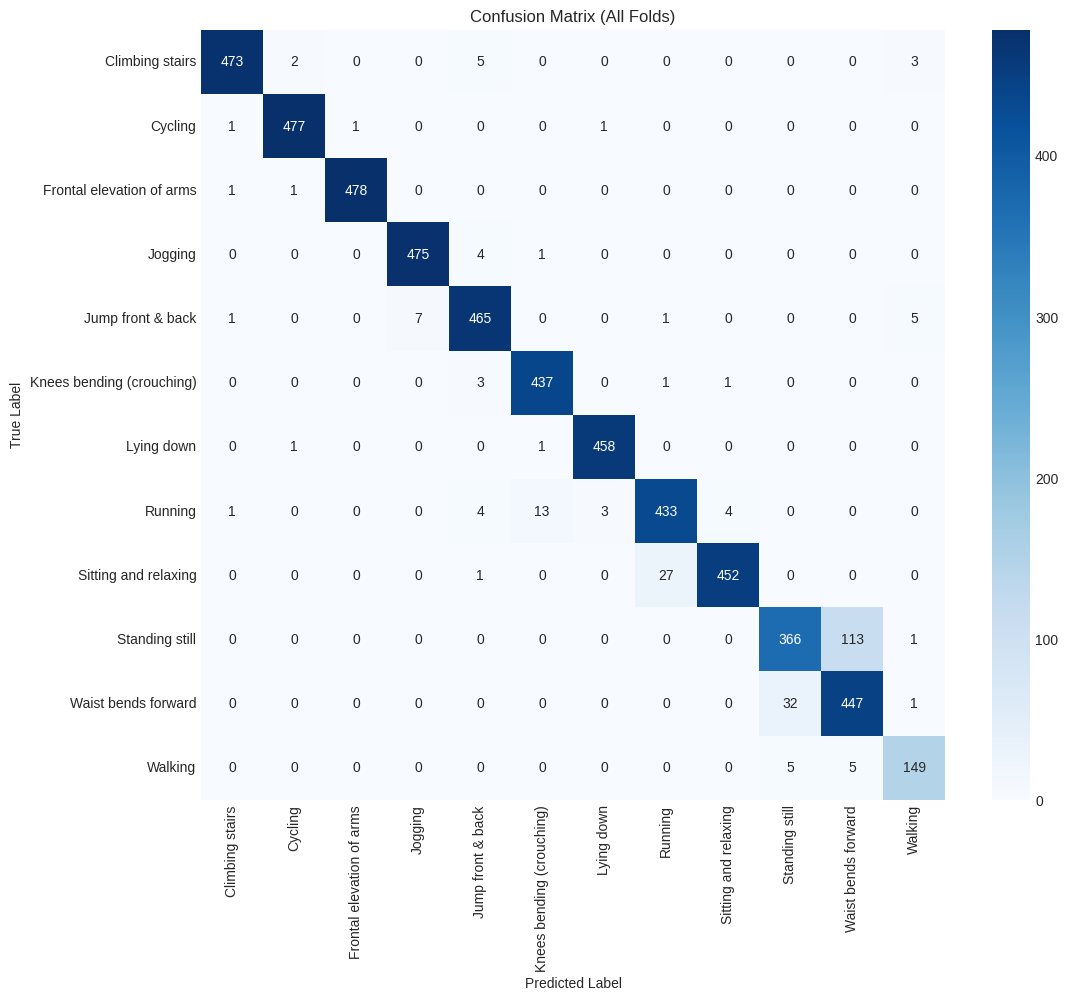

In [18]:
# --- 8. Classification Report & Confusion Matrix ---
print("\n--- 8. Classification Report & Confusion Matrix ---")
target_names_actual = [le.classes_[i] for i in sorted(np.unique(y))]

print(classification_report(all_labels, all_preds, target_names=target_names_actual))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_actual, yticklabels=target_names_actual)
plt.title('Confusion Matrix (All Folds)'); plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()